# __Transmissivity coupling of fracture stress-state__

### Problem statement


In this tutorial, we investigate the impact of hydromechanical coupling between rock mass equivalent permeability and in situ stress conditions.
<br>
To do so, we set fracture transmissivities as a function of applied normal stress.

### Theoretical background

The fracture stress-state can be estimated using two different models:
- __remote__: fractures are considered isolated, the applied force depends only on the remote stress $\sigma_{\infty}$
- __interactions__: stress fluctuations due to multiple fractures are accounted ([Kachanov, 1989](http://scholar.google.fr/scholar_url?url=https://www.researchgate.net/profile/Jean_Philippe_Laures2/publication/226681022_Three-dimensional_problems_of_strongly_interacting_arbitrarily_located_penny-shaped_cracks/links/5bdf1d3592851c6b27a786a4/Three-dimensional-problems-of-strongly-interacting-arbitrarily-located-penny-shaped-cracks.pdf&hl=fr&sa=X&ei=KudlYJDkFYaQmwGTw6HwAw&scisig=AAGBfm2kYAgxJ_j4gFkTTE_P_UF8g-pxQA&nossl=1&oi=scholarr))

Different relations between fracture aperture and applied stress can then be used to assign fracture transmissivity, using the cubic law ([Snow, 1965](https://ci.nii.ac.jp/naid/10011929254/)).

### What will you learn ?

- Compute fracture stress-state
- Assign hydraulic properties correlated to this stress-state

### DFN.Lab model


The required module is __Mechanics__.

In [1]:
import dfnlab.Mechanics as mech

_____________

### Initialize system

First, we initialize the system, made of a cubic domain and import a DFN from disk file.

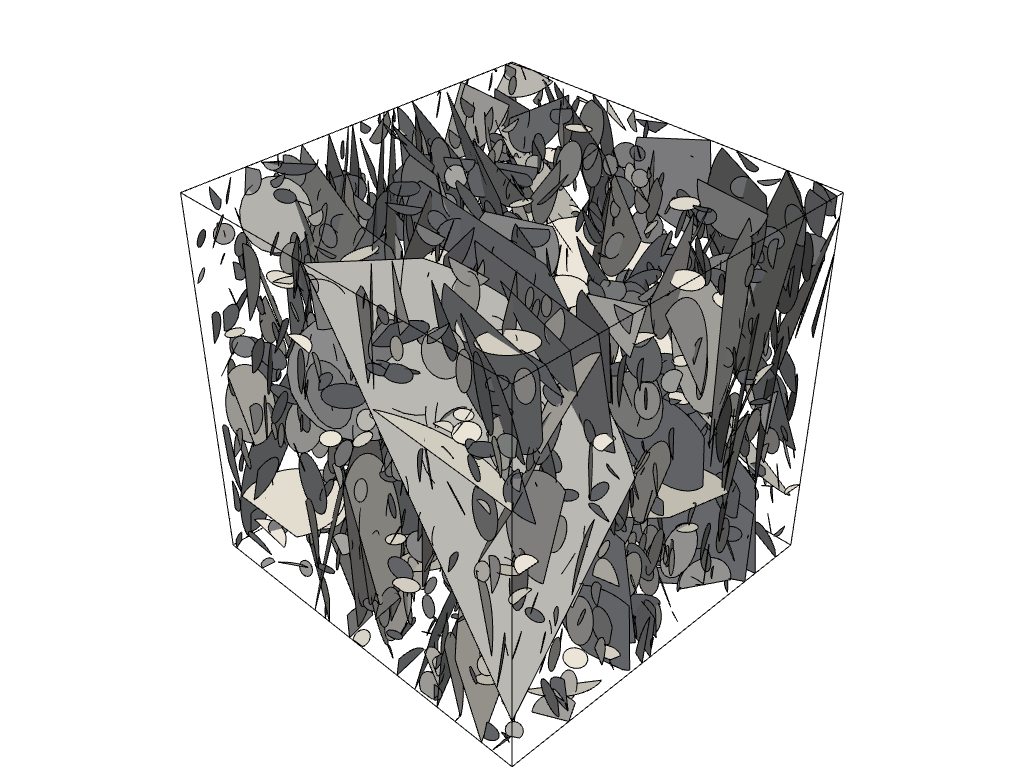

In [2]:
import dfnlab.System as sys 
import dfnlab.Domains as dom 
import dfnlab.Fractures as dfn
import dfnlab.IO as io
import os 

system = sys.System()
domain = dom.Domain()
domain.buildParallelepiped(center=[0, 0, 0], L1=40)
system.setDomain(domain)
fnet = dfn.DFN()
system.setDFN(fnet)
io.load_DFN_file(fnet, 'sources/ffm01.disk', format="disk") 
system.build()

from sources.functions import plot_dfn
plot_dfn(system)

### Create a mechanical system

Then, you need to create a _SystemMechanics_ object from the system, and the remote stress field.
<br>
The stress model must be specified as a property.

In [3]:
remoteStress = mech.Stress(s1=-23.9e6,trend1=145,plunge1=0,s2=-13.6e6,trend2=-1,plunge2=-1,s3=-5.3e6,trend3=0,plunge3=90)

sysmech = mech.Mechanics(system,remoteStress)
sysmech.addProperties("stress_model", "remote")

Rock matrix elastic mechanical properties need to be assigned.

In [4]:
sysmech.addProperties("young", 53e9)
sysmech.addProperties("poisson", 0.25)

Then, you can solve the mechanical system.

In [5]:
sysmech.solve()

Here we store applied normal and shear stress on all fractures.

In [6]:
import numpy as np

sigmaN_list=[]
tau_list=[]
for frac in fnet:
    sigmaN = frac.getForceNormal()
    sigmaN_list.append(abs(sigmaN))
    tau = np.linalg.norm(frac.getForceShear())
    tau_list.append(tau)

And plot the fracture stress conditions in a Mohr plot.

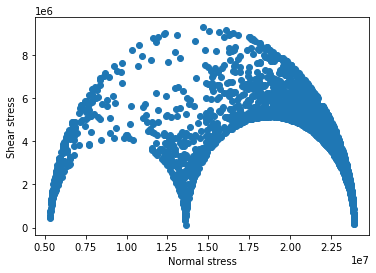

In [7]:
import matplotlib.pyplot as plt
plt.scatter(sigmaN_list,tau_list);
plt.xlabel("Normal stress");
plt.ylabel("Shear stress");

And the applied normal stress distribution.

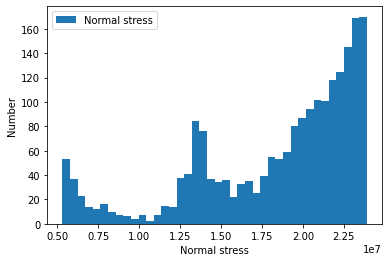

In [8]:
plt.hist(sigmaN_list,40,label="Normal stress");
plt.xlabel("Normal stress");
plt.ylabel("Number");
plt.legend();

### Assign stress-correlated fracture transmissivities

We compute fracture hydraulic aperture $e_h$ from the applied normal stress using an exponential relation:

$e_h = e_{hr} + (e_{max}-e_{hr}) . e^{-\alpha.\sigma_n}$

where $e_{hr}=5\mu m$ and $e_{max}=90 \mu m$ are residual and maximum aperture respectively.
<br>
Transmisisvities $T$ are then defined using the cubic law:

$T = \frac{\rho . g}{12.\mu} e_h ^3 = \frac{e_h ^3}{12} 10^7$

In [9]:
er=5e-6
em=90e-6
alpha=0.15

First we initialize the _DFNproperties_.

In [10]:
import dfnlab.MaterialProperties as mat

dfnprop = mat.DFNProperties(fnet)
fnet.addProperties("transmissivities", dfnprop)

And assign a transmissivity value to each fracture, depending on its applied normal stress.

In [11]:
import dfnlab.ObjectProperties as op
import math

T_list=[]
for frac in fnet:
    sigmaN = frac.getForceNormal()
    aperture = er+(em-er)*math.exp(-alpha*max(abs(sigmaN),0)/1e6)
    T = (aperture**3)/(12*1e-7)
    T_list.append(T)
    trans = op.ObjectProperty(T)
    dfnprop.setProperty(frac,trans)

We plot below the fracture transmissivity distribution.

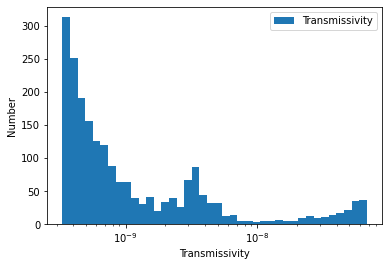

In [12]:
hist, bins = np.histogram(T_list, bins=40)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(T_list, bins=logbins, label="Transmissivity")
plt.xscale('log')
plt.xlabel("Transmissivity");
plt.ylabel("Number");
plt.legend();

### Compute hydraulic conductivity tensor

Here we compute the hydraulic conductivity tensor of the imported DFN.

In [13]:
import dfnlab.HydraulicTensors as ht

pT = ht.PermeabilityTensor(system)
hc_spheroid = pT.hydraulicConductivitySpheroid()
hc_spheroid.fitEllipsoid()
print("Hydraulic conductivity tensor principal directions are \n"+"\n".join([str(i) for i in hc_spheroid.ellipsoidPrincipalDirections()]))
print("Hydraulic conductivity tensor principal values are \n"+"\n".join(["{:.3e}".format(i) for i in hc_spheroid.ellipsoidPrincipalValues()]))

Hydraulic conductivity tensor principal directions are 
[0.97729099 0.011519   0.21158837]
[-0.0861383   0.93389495  0.34701645]
[ 0.19360403  0.35736191 -0.91367934]
Hydraulic conductivity tensor principal values are 
5.994e-10
1.195e-10
6.114e-11
